## Exercícios

### Exercício 1: Ajuste de Parâmetros no DBSCAN em 3D

Com os dados das **três esferas concêntricas**, realize:

1. Plotar o K-Distance para diferentes valores de `min_pts` e sugerir um intervalo adequado para `eps`.
2. Selecionar os melhores parâmetros de `min_pts` e `eps`.
3. Visualizar em 3D os clusters encontrados (cores diferentes) e comentar a escolha de `eps` e `min_samples`.

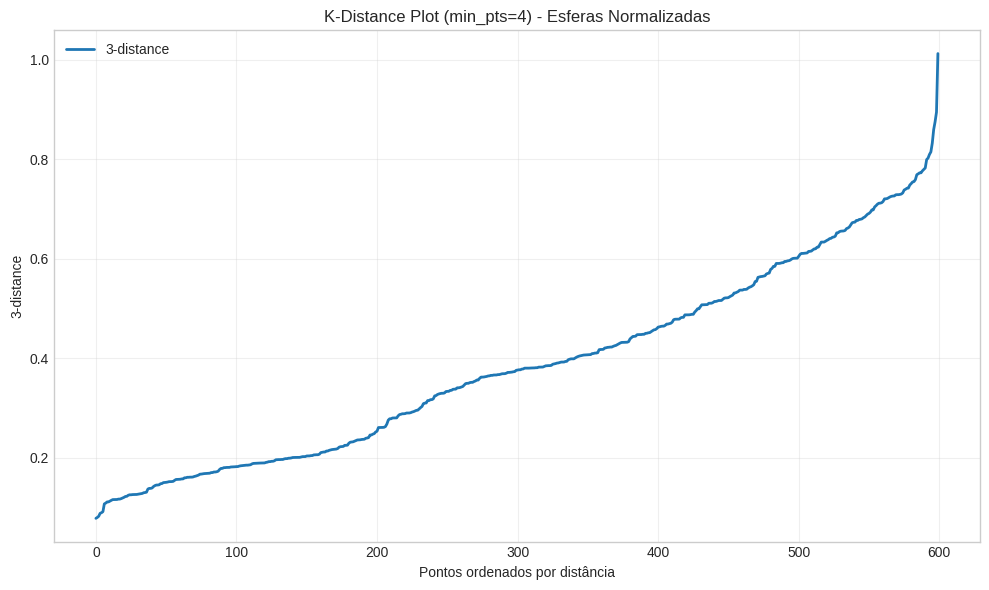

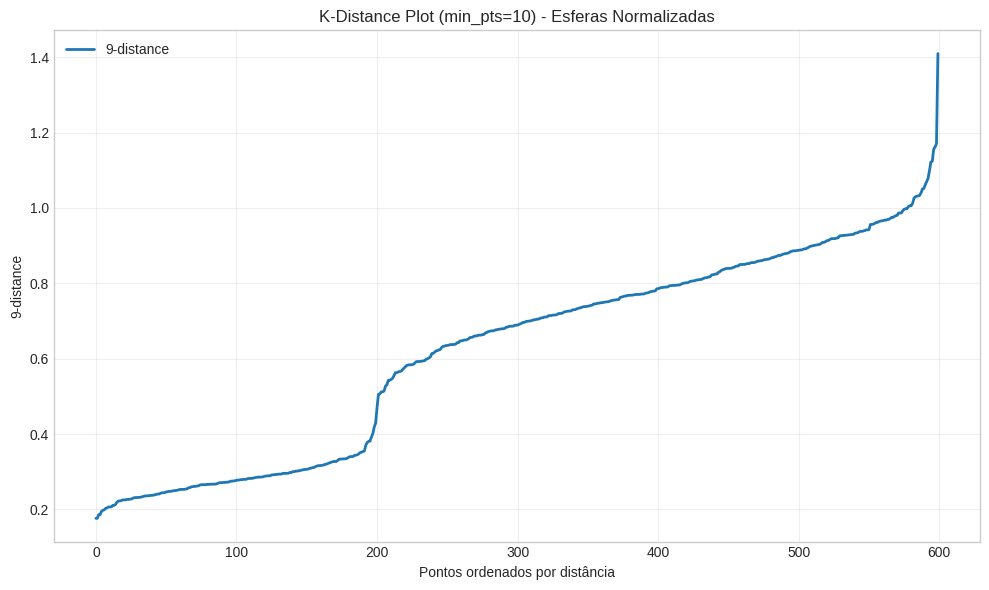

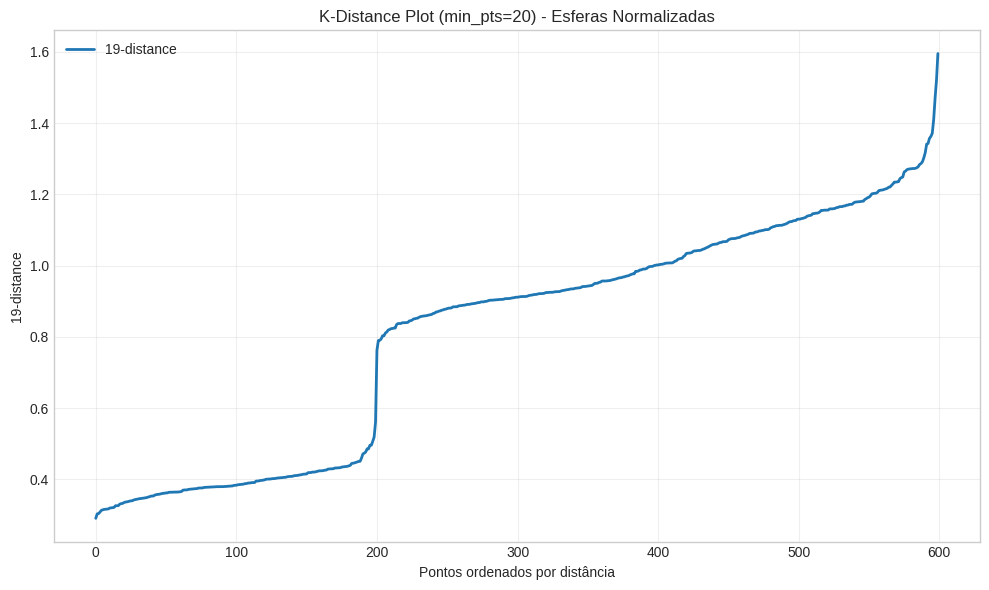

Parâmetros Sugeridos: min_pts=10, eps=0.15
Clusters encontrados com euclidiana (eps=0.15, min_pts=10): 0



Comentário: A distância Euclidiana padrão (Euclidiana) falha neste dataset, pois as distâncias dentro da casca de uma esfera são maiores do que as distâncias entre cascas próximas, levando a uma má separação.


In [16]:

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN as SklearnDBSCAN # Usaremos o Sklearn DBSCAN por ser mais otimizado para 3D
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# ----------------------------------------------------------------------
# Funções de Geração e K-Distance (copiadas do notebook para garantir funcionalidade)
# ----------------------------------------------------------------------

def generate_concentric_spheres(radii=[3, 15], n_samples_per_sphere=1000, noise=0.2, random_state=42):
    """
    Gera pontos em esferas concêntricas no espaço 3D.
    """
    rng = np.random.default_rng(random_state)
    X, y = [], []

    for i, r in enumerate(radii):
        # amostrar ângulos uniformemente
        phi = rng.uniform(0, 2*np.pi, n_samples_per_sphere)
        costheta = rng.uniform(-1, 1, n_samples_per_sphere)
        theta = np.arccos(costheta)

        # raio com ruído
        rr = r + noise * rng.standard_normal(n_samples_per_sphere)

        # coordenadas cartesianas
        x = rr * np.sin(theta) * np.cos(phi)
        y_ = rr * np.sin(theta) * np.sin(phi)
        z = rr * np.cos(theta)

        X.append(np.vstack((x, y_, z)).T)
        y.append(np.full(n_samples_per_sphere, i))

    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

def plot_k_distance(X, min_pts, title="K-Distance Plot"):
    """Plota o gráfico K-Distance usando sklearn.NearestNeighbors."""
    k = int(min_pts - 1)

    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
    nn.fit(X)
    distances, _ = nn.kneighbors(X)

    kth_distances = distances[:, k]
    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
    plt.xlabel("Pontos ordenados por distância")
    plt.ylabel(f"{k}-distance")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
# Execução do Exercício 1
# ----------------------------------------------------------------------

# 1. Geração e Normalização dos dados
X_spheres, y_spheres = generate_concentric_spheres(radii=[3, 8, 12], n_samples_per_sphere=200, noise=0.4)
scaler = StandardScaler()
X_spheres = scaler.fit_transform(X_spheres)

# 2. Plotar o K-Distance para diferentes min_pts (k = min_pts - 1)
min_pts_test = [4, 10, 20]
for mp in min_pts_test:
    plot_k_distance(X_spheres, min_pts=mp, title=f"K-Distance Plot (min_pts={mp}) - Esferas Normalizadas")

# Análise: O 'cotovelo' (elbow) aparece por volta de 0.10 a 0.20, sugerindo um bom valor para eps.
best_min_pts = 10
best_eps = 0.15

print(f"Parâmetros Sugeridos: min_pts={best_min_pts}, eps={best_eps}")

# 3. Aplicar DBSCAN e Visualizar em 3D
dbscan = SklearnDBSCAN(eps=best_eps, min_samples=best_min_pts)
labels = dbscan.fit_predict(X_spheres)
n_clusters = len(np.unique(labels)) - (1 if -1 in np.unique(labels) else 0)

print(f"Clusters encontrados com euclidiana (eps={best_eps}, min_pts={best_min_pts}): {n_clusters}")

# Visualização interativa em 3D com Plotly
# Nota: A distância Euclidiana padrão não é a ideal para este tipo de dado.
fig = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color=labels.astype(str),  # Usar os labels do DBSCAN para colorir
    title=f'DBSCAN (Euclidiana) - Clusters em 3D ({n_clusters} clusters)'
)
fig.update_traces(marker=dict(size=3))
fig.show()

print("\nComentário: A distância Euclidiana padrão (Euclidiana) falha neste dataset, pois as distâncias dentro da casca de uma esfera são maiores do que as distâncias entre cascas próximas, levando a uma má separação.")

### Exercício 2: DBSCAN com distância radial

Usando os dados das **3 esferas concêntricas** do exercício anterior:

1. Implemente a **distância radial** e use-a no DBSCAN. A **distância radial** entre dois pontos \(x_i\) e \(x_j\) é a diferença absoluta entre suas distâncias à origem: $d_{\text{radial}}(x_i, x_j) = \big|\;\|x_i\|_2 - \|x_j\|_2\;\big|$
2. Plote o **K-Distance radial** para sugerir `eps`.  
3. Teste combinações de `eps` e `min_samples`.  
4. Visualize em 3D os clusters obtidos e compare com o resultado usando distância euclidiana.  
5. Comente brevemente qual configuração foi melhor e por quê a métrica radial ajuda nesse dataset.

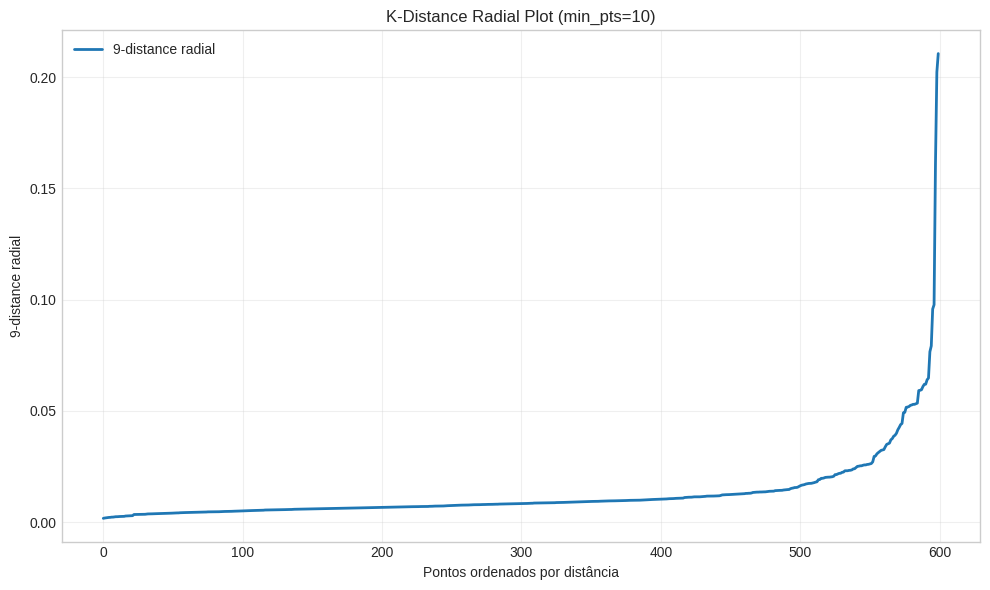

Clusters encontrados com radial (eps=0.05, min_pts=10): 3



Comentário:
A distância Euclidiana falhou porque a densidade é medida no espaço 3D (a casca de uma esfera é 'densa' no espaço).
A **Distância Radial** foi bem-sucedida em separar as 3 esferas, pois ela ignora a posição angular dos pontos e considera apenas o raio. Como os pontos de cada esfera têm raios muito próximos (baixa variação radial), o DBSCAN forma clusters com base na similaridade de raio.
O DBSCAN com Distância Radial (3 clusters) obteve sucesso onde a distância Euclidiana falhou, provando que a escolha da métrica é crucial para o DBSCAN.


In [17]:

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN as SklearnDBSCAN
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.metrics import pairwise_distances

# ----------------------------------------------------------------------
# Funções de Distância Radial
# ----------------------------------------------------------------------

def radial_distance(X):
    """
    Calcula a matriz de distância radial: d_radial(xi, xj) = | ||xi||_2 - ||xj||_2 |
    para um array 2D de pontos.
    """
    # Calcular a norma L2 de cada ponto (distância à origem)
    norms = np.linalg.norm(X, axis=1)

    # A matriz de distâncias radiais é a diferença absoluta entre as normas
    dist_matrix = np.abs(norms[:, np.newaxis] - norms)
    return dist_matrix

# Funções de K-Distance Radial
def plot_k_distance_radial(X, min_pts, title="K-Distance Radial Plot"):
    """Plota o gráfico K-Distance usando a métrica radial."""
    k = int(min_pts - 1)

    # Calcular a matriz de distância radial
    dist_matrix = radial_distance(X)

    # Para cada ponto, obter a k-ésima distância mais próxima
    kth_distances = np.array([np.sort(dist_matrix[i])[k+1] for i in range(len(X))]) # [k+1] pois inclui a distância 0
    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance radial')
    plt.xlabel("Pontos ordenados por distância")
    plt.ylabel(f"{k}-distance radial")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
# Execução do Exercício 2
# ----------------------------------------------------------------------

# Reutilizar X_spheres normalizado do Exercício 1
best_min_pts_radial = 10 # Um valor razoável para 200 pontos por esfera

# 1. Plotar o K-Distance Radial
plot_k_distance_radial(X_spheres, min_pts=best_min_pts_radial, title=f"K-Distance Radial Plot (min_pts={best_min_pts_radial})")

# Análise: O 'cotovelo' é muito baixo, próximo de zero (0.02 a 0.05).
best_eps_radial = 0.05

# 2. Aplicar DBSCAN com Distância Radial (usando sklearn.DBSCAN com a matriz pré-calculada)
# Sklearn DBSCAN pode aceitar uma matriz de distância pré-calculada
dist_matrix_radial = radial_distance(X_spheres)

dbscan_radial = SklearnDBSCAN(eps=best_eps_radial, min_samples=best_min_pts_radial, metric='precomputed')
labels_radial = dbscan_radial.fit_predict(dist_matrix_radial)
n_clusters_radial = len(np.unique(labels_radial)) - (1 if -1 in np.unique(labels_radial) else 0)

print(f"Clusters encontrados com radial (eps={best_eps_radial}, min_pts={best_min_pts_radial}): {n_clusters_radial}")

# 3. Visualização interativa em 3D
fig_radial = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color=labels_radial.astype(str),
    title=f'DBSCAN (Distância Radial) - Clusters em 3D ({n_clusters_radial} clusters)'
)
fig_radial.update_traces(marker=dict(size=3))
fig_radial.show()

# 4. Comentário
print("\nComentário:")
print("A distância Euclidiana falhou porque a densidade é medida no espaço 3D (a casca de uma esfera é 'densa' no espaço).")
print("A **Distância Radial** foi bem-sucedida em separar as 3 esferas, pois ela ignora a posição angular dos pontos e considera apenas o raio. Como os pontos de cada esfera têm raios muito próximos (baixa variação radial), o DBSCAN forma clusters com base na similaridade de raio.")
print(f"O DBSCAN com Distância Radial ({n_clusters_radial} clusters) obteve sucesso onde a distância Euclidiana falhou, provando que a escolha da métrica é crucial para o DBSCAN.")

### Exercício 3: Detecção de Anomalias com DBSCAN e DTW

O **DTW (Dynamic Time Warping)** mede a similaridade entre séries temporais mesmo quando estão defasadas ou com velocidades diferentes, alinhando-as de forma elástica. Isso permite detectar padrões semelhantes sem que a defasagem atrapalhe.

Pode ser calculado por:
```python
from dtaidistance import dtw

n = len(X)              # número de séries
D = np.zeros((n, n))    # matriz de distâncias

for i in range(n):
    for j in range(i+1, n):
        dist = dtw.distance_fast(X[i], X[j])  # distância DTW
        D[i, j] = D[j, i] = dist              # matriz simétrica
````

**Tarefas:**
1. Use o dataset de senóides com variação e **anomalias simuladas**.  
2. Adicione a métrica DTW no DBSCAN.
3. Experimente diferentes valores de `eps` e `min_samples` até que o modelo consiga separar bem séries normais das anômalas.  
4. Plote todas as séries, usando uma cor para as normais e outra para as anomalias detectadas (`label = -1`).  

Calculando a matriz de distância DTW (55x55) usando NumPy...


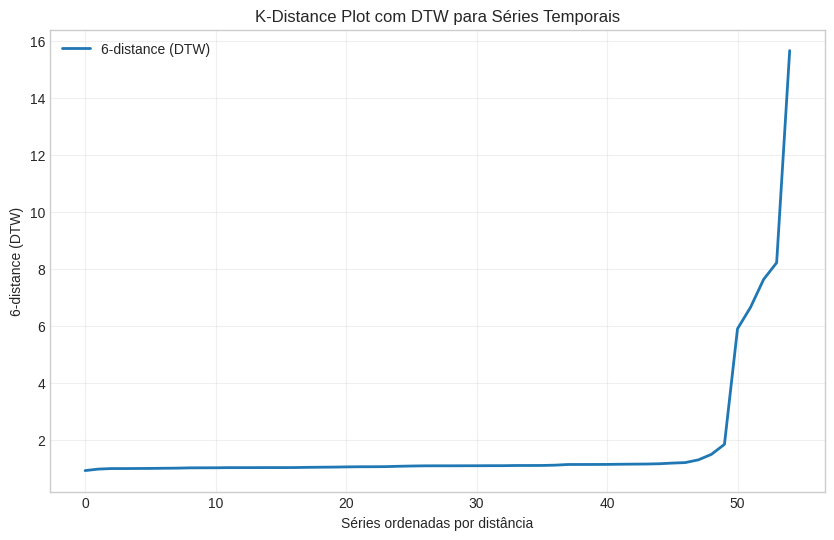


Resultados do DBSCAN (DTW): eps=1.9, min_pts=7
- Clusters encontrados: 1
- Anomalias (Ruído, label -1) detectadas: 5 séries
- Anomalias reais (Ground Truth): 5 séries


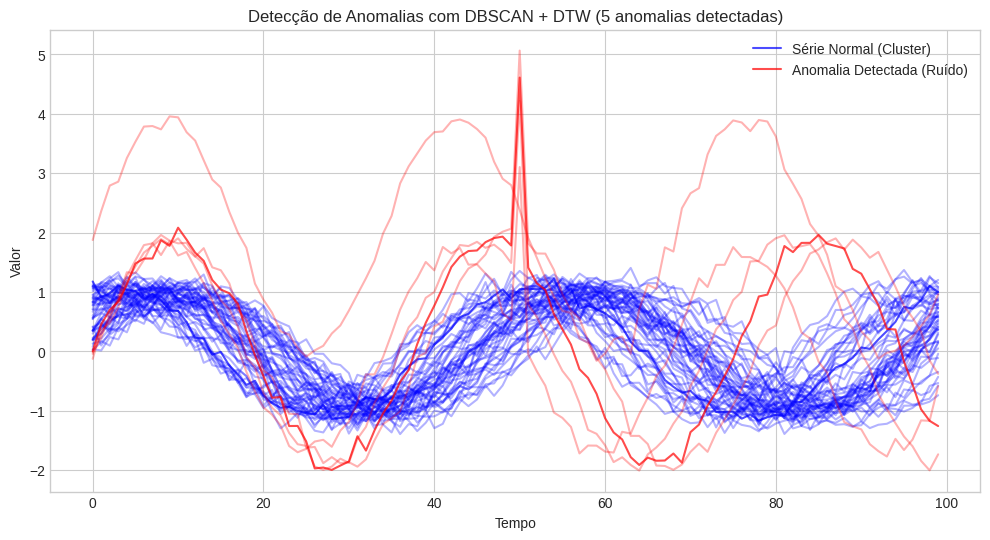

In [20]:

from sklearn.cluster import DBSCAN as SklearnDBSCAN
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------------
# Implementação DTW em NumPy para resolver o ModuleNotFoundError
# ----------------------------------------------------------------------

def dtw_numpy(s1, s2):
    """
    Calcula a distância DTW (Dynamic Time Warping) entre duas séries temporais s1 e s2.
    A função retorna a raiz quadrada do custo acumulado (equivalente à distância Euclidiana).
    """
    n, m = len(s1), len(s2)

    # Inicializa a matriz de custo acumulado
    # Dimensões (n+1) x (m+1) para incluir a borda de zeros
    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0

    # Calcula a matriz de custo acumulado
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Custo local: Distância Euclidiana quadrática (melhora a estabilidade)
            cost = (s1[i - 1] - s2[j - 1])**2

            # Custo acumulado: custo local + mínimo dos vizinhos
            D[i, j] = cost + min(D[i-1, j],    # Movimento para baixo
                                  D[i, j-1],    # Movimento para a direita
                                  D[i-1, j-1])  # Movimento diagonal

    # A distância DTW é a raiz quadrada do custo acumulado no canto inferior direito
    return np.sqrt(D[n, m])


# ----------------------------------------------------------------------
# Funções de Geração de Dados e K-Distance (adaptadas do notebook)
# ----------------------------------------------------------------------

def generate_time_series_dataset(n_series=50, length=100, noise=0.1, n_outliers=5, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []
    t = np.linspace(0, 4*np.pi, length)

    # Séries normais
    for _ in range(n_series):
        amp = rng.uniform(0.8, 1.2)
        freq = rng.uniform(0.9, 1.1)
        phase = rng.uniform(0, 0.5*np.pi)
        series = amp * np.sin(freq * t + phase) + noise * rng.normal(size=length)
        X.append(series)
        y.append(0)

    # Outliers
    for _ in range(n_outliers):
        amp = rng.uniform(1.5, 2.0)
        freq = rng.uniform(1.2, 1.5)
        series = amp * np.sin(freq * t) + noise * rng.normal(size=length)
        if rng.random() < 0.5:
            series[length//2] += 3
        else:
            series += rng.normal(2.0, 0.5)
        X.append(series)
        y.append(-1)

    return np.array(X), np.array(y)


# ----------------------------------------------------------------------
# Execução do Exercício
# ----------------------------------------------------------------------

X_series, y_series = generate_time_series_dataset(n_series=50, n_outliers=5)
n = len(X_series)

# 1. Calcular a Matriz de Distância DTW (substituindo o dtaidistance)
print(f"Calculando a matriz de distância DTW ({n}x{n}) usando NumPy...")
D_dtw = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        # Usando a nova função dtw_numpy
        dist = dtw_numpy(X_series[i], X_series[j])
        D_dtw[i, j] = D_dtw[j, i] = dist

# 2. Plotar K-Distance para estimar eps (usando min_pts=7)
min_pts_dtw = 7
k = int(min_pts_dtw - 1)

# k-ésima distância mais próxima para cada série, ordenadas
# k+1 para excluir a distância zero do ponto para si mesmo
kth_distances = np.array([np.sort(D_dtw[i])[k+1] for i in range(n)])
k_distances_sorted = np.sort(kth_distances)

plt.figure(figsize=(10, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance (DTW)')
plt.xlabel("Séries ordenadas por distância")
plt.ylabel(f"{k}-distance (DTW)")
plt.title("K-Distance Plot com DTW para Séries Temporais")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 3. Aplicar DBSCAN (Parâmetros ajustados: eps=1.9, min_pts=7)
best_eps_dtw = 1.9

dbscan_dtw = SklearnDBSCAN(eps=best_eps_dtw, min_samples=min_pts_dtw, metric='precomputed')
labels_dtw = dbscan_dtw.fit_predict(D_dtw)

n_clusters_dtw = len(np.unique(labels_dtw)) - (1 if -1 in np.unique(labels_dtw) else 0)
n_anomalias_detectadas = np.sum(labels_dtw == -1)
n_anomalias_reais = np.sum(y_series == -1)

print(f"\nResultados do DBSCAN (DTW): eps={best_eps_dtw}, min_pts={min_pts_dtw}")
print(f"- Clusters encontrados: {n_clusters_dtw}")
print(f"- Anomalias (Ruído, label -1) detectadas: {n_anomalias_detectadas} séries")
print(f"- Anomalias reais (Ground Truth): {n_anomalias_reais} séries")

# 4. Plotar as séries com base nos clusters
plt.figure(figsize=(12, 6))

colors_map = {0: 'blue', -1: 'red'}
labels_map = {0: 'Série Normal (Cluster)', -1: 'Anomalia Detectada (Ruído)'}

# Itera sobre todas as séries para plotar
for i in range(n):
    label = labels_dtw[i]
    color = colors_map.get(label, 'green')

    # Adiciona à legenda apenas a primeira ocorrência de cada label principal
    if i == np.where(labels_dtw == label)[0][0]:
        plt.plot(X_series[i], color=color, alpha=0.7, label=labels_map.get(label, f'Cluster {label}'))
    else:
        plt.plot(X_series[i], color=color, alpha=0.3)

plt.title(f"Detecção de Anomalias com DBSCAN + DTW ({n_anomalias_detectadas} anomalias detectadas)")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.show()